In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

# =========================================================
# 1. CARICAMENTO E PULIZIA DEL FILE UNDERSTAT 24/25
# =========================================================

# Carica l'Excel che hai esportato da Understat
df = pd.read_excel("C:\\Users\\loren\\Downloads\\UnderStat24-25.xlsx")   # stesso nome del file allegato

print("Colonne originali:")
print(df.columns)

# Dovresti avere qualcosa tipo:
# ['№','Team','M','W','D','L','G','GA','PTS','xG','NPxG',
#  'xGA','NPxGA','NPxGD','PPDA','OPPDA','DC','ODC','xPTS']

# Funzione per estrarre la parte numerica principale prima di + o -
def extract_main_value(s):
    if isinstance(s, str):
        # Rimuovi eventuali spazi
        s = s.strip()
        # Se contiene + o -, prendi la parte prima del segno
        for sep in ['+', '-']:
            # Attenzione: il '-' può essere segno del numero
            # ma Understat usa formato tipo "57.05-1.95", quindi lo split va bene.
            if sep in s[1:]:  # ignora il primo carattere per non confondere il segno
                parts = s.split(sep)
                return float(parts[0])
        # se non ci sono + o -, prova a convertire tutto
        try:
            return float(s)
        except ValueError:
            return np.nan
    return s

cols_with_plus_minus = ["xG", "NPxG", "xGA", "NPxGA", "NPxGD", "xPTS"]

for col in cols_with_plus_minus:
    if col in df.columns:
        df[col] = df[col].apply(extract_main_value)

# Rinomina alcune colonne in qualcosa di più chiaro
df = df.rename(columns={
    "№": "rank",
    "Team": "team",
    "M": "matches",
    "G": "goals_for",
    "GA": "goals_against"
})

# Converte alcune colonne numeriche, se necessario
num_cols = [
    "rank", "matches", "W", "D", "L", "goals_for", "goals_against",
    "PTS", "xG", "NPxG", "xGA", "NPxGA", "NPxGD",
    "PPDA", "OPPDA", "DC", "ODC", "xPTS"
]
for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# =========================================================
# 2. METRICHE DERIVATE
# =========================================================

# Differenze gol e xG
df["goal_diff"] = df["goals_for"] - df["goals_against"]
df["xg_diff"] = df["xG"] - df["xGA"]

# Over/under-performance in termini di gol
df["xg_overperf"] = df["goals_for"] - df["xG"]   # >0: segna più dei propri xG

# Over/under-performance in termini di punti
df["pts_overperf"] = df["PTS"] - df["xPTS"]      # >0: fa più punti degli xPTS

# xG e xGA per partita (per normalizzare)
df["xG_per_match"] = df["xG"] / df["matches"]
df["xGA_per_match"] = df["xGA"] / df["matches"]
df["goals_for_per_match"] = df["goals_for"] / df["matches"]
df["goals_against_per_match"] = df["goals_against"] / df["matches"]

# Normalizzazione semplice 0–1 per radar (z-score o min-max)
def min_max_norm(s):
    return (s - s.min()) / (s.max() - s.min())

df["norm_xG"] = min_max_norm(df["xG_per_match"])
df["norm_xGA_inv"] = min_max_norm(-df["xGA_per_match"])  # più alto = difesa migliore
df["norm_PPDA_inv"] = min_max_norm(-df["PPDA"])          # più alto = pressing più aggressivo
df["norm_DC"] = min_max_norm(df["DC"])
df["norm_ODC_inv"] = min_max_norm(-df["ODC"])            # meno ODC concesse = meglio
df["norm_xPTS"] = min_max_norm(df["xPTS"] / df["matches"])

# Salva dataset pulito per ogni uso
df.to_csv("serie_a_24_25_clean_enriched.csv", index=False)
print("Salvato: serie_a_24_25_clean_enriched.csv")

# =========================================================
# LOGHI DELLE SQUADRE
# =========================================================

import os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.image import imread

# percorso cartella loghi - ADATTALO
logo_dir = r"C:\Users\loren\OneDrive\Desktop\Data Science\Data Visualization\Loghi Serie A"

team_logo_map = {
    "Napoli": os.path.join(logo_dir, "Napoli.png"),
    "Inter": os.path.join(logo_dir, "Inter.png"),
    "Atalanta": os.path.join(logo_dir, "Atalanta.png"),
    "Juventus": os.path.join(logo_dir, "Juventus.png"),
    "Roma": os.path.join(logo_dir, "Roma.png"),
    "Fiorentina": os.path.join(logo_dir, "Fiorentina.png"),
    "Lazio": os.path.join(logo_dir, "Lazio.png"),
    "Milan": os.path.join(logo_dir, "Milan.png"),
    "Bologna": os.path.join(logo_dir, "Bologna.png"),
    "Como": os.path.join(logo_dir, "Como.png"),
    "Torino": os.path.join(logo_dir, "Torino.png"),
    "Udinese": os.path.join(logo_dir, "Udinese.png"),
    "Genoa": os.path.join(logo_dir, "Genoa.png"),
    "Verona": os.path.join(logo_dir, "Verona.png"),
    "Parma": os.path.join(logo_dir, "Parma.png"),
    "Cagliari": os.path.join(logo_dir, "Cagliari.png"),
    "Lecce": os.path.join(logo_dir, "Lecce.png"),
    "Empoli": os.path.join(logo_dir, "Empoli.png"),
    "Venezia": os.path.join(logo_dir, "Venezia.png"),
    "Monza": os.path.join(logo_dir, "Monza.png"),
}

def add_logo(ax, x, y, team, zoom=0.06):
    path = team_logo_map.get(team)
    if path is None or not os.path.exists(path):
        return
    img = imread(path)
    im = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(im, (x, y), frameon=False)
    ax.add_artist(ab)

Colonne originali:
Index(['№', 'Team', 'M', 'W', 'D', 'L', 'G', 'GA', 'PTS', 'xG', 'NPxG', 'xGA',
       'NPxGA', 'NPxGD', 'PPDA', 'OPPDA', 'DC', 'ODC', 'xPTS'],
      dtype='object')
Salvato: serie_a_24_25_clean_enriched.csv


### Performance Matrix (Grafico 1)

C:\Users\loren\AppData\Local\Temp\ipykernel_32860\2448413145.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("viridis_r")


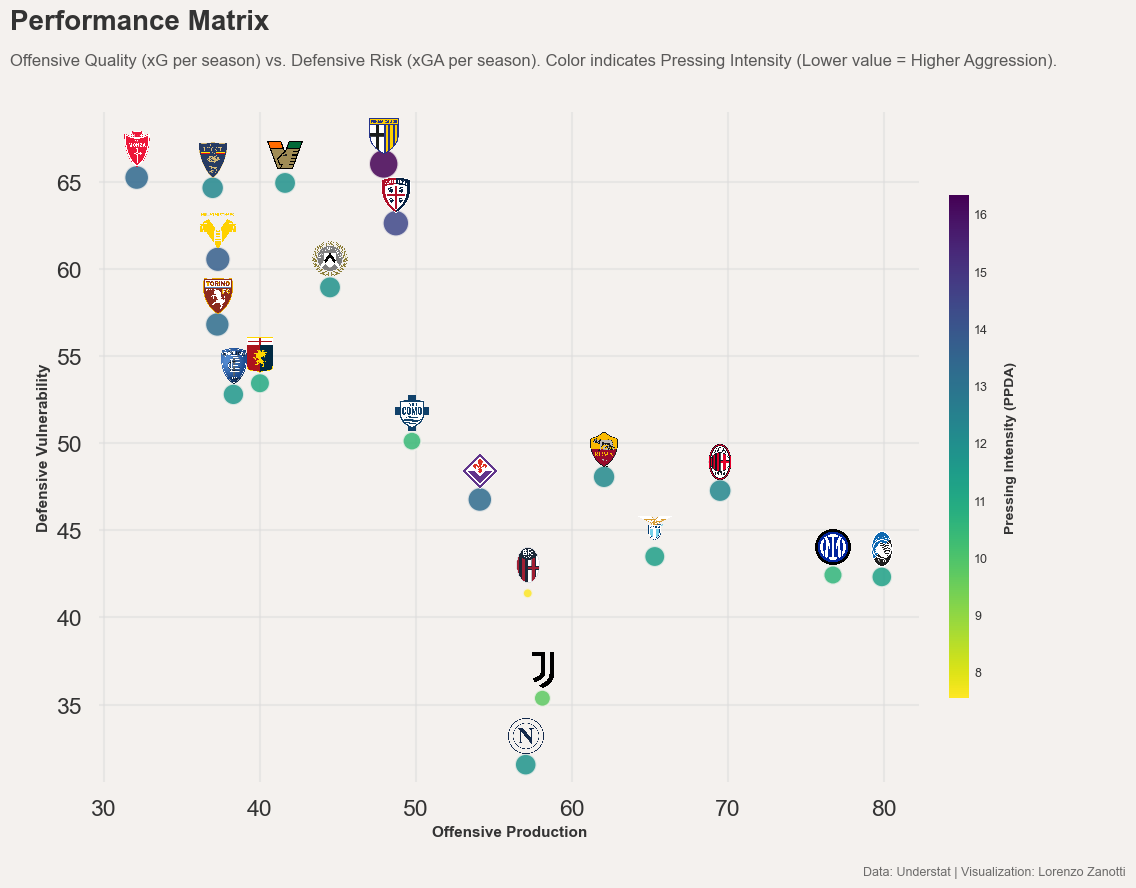

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
import matplotlib as mpl

# --- 1. SETUP STILE "GIORNALISTICO CHIARO" (stile The Economist/Financial Times) ---
BG_COLOR = '#F4F1EE' # Un bianco avorio, non sparato
TEXT_COLOR = '#333333' # Un grigio scuro, non nero puro
GRID_COLOR = '#DCDCDC' # Una griglia molto leggera

plt.rcParams.update({
    'figure.facecolor': BG_COLOR, 'axes.facecolor': BG_COLOR, 'text.color': TEXT_COLOR,
    'axes.labelcolor': TEXT_COLOR, 'xtick.color': TEXT_COLOR, 'ytick.color': TEXT_COLOR,
    'grid.color': GRID_COLOR, 'axes.spines.top': False, 'axes.spines.right': False,
    'axes.spines.left': False, 'axes.spines.bottom': False
})

# --- Se preferisci comunque il TEMA DARK, decommenta questo blocco e commenta quello sopra ---
# BG_COLOR = '#0e1117'
# TEXT_COLOR = '#E0E0E0'
# GRID_COLOR = '#444444'
# plt.rcParams.update({
#     'figure.facecolor': BG_COLOR, 'axes.facecolor': BG_COLOR, 'text.color': TEXT_COLOR,
#     'axes.labelcolor': TEXT_COLOR, 'xtick.color': TEXT_COLOR, 'ytick.color': TEXT_COLOR,
#     'grid.color': GRID_COLOR, 'axes.spines.top': False, 'axes.spines.right': False,
#     'axes.spines.left': False, 'axes.spines.bottom': False
# })

# --- 2. PLOT ---
fig, ax = plt.subplots(figsize=(12, 9))

# Scatter: colore/dimensione = PPDA
sns.scatterplot(
    data=df,
    x="xG",
    y="xGA",
    size="PPDA",
    sizes=(50, 450),
    hue="PPDA",
    palette="viridis_r",
    alpha=0.85,
    edgecolor=BG_COLOR, # Bordo dello stesso colore dello sfondo per un effetto "morbido"
    linewidth=1.5,
    ax=ax,
    legend=False
)

# nuovo: imposta esplicitamente i limiti y
y_min = df["xGA"].min() - 1      # un po' di margine sotto
y_max = df["xGA"].max() + 3     # più spazio sopra per i loghi
ax.set_ylim(y_min, y_max)

# LOGHI: piccoli e staccati
for _, row in df.iterrows():
    x, y, team = row["xG"], row["xGA"], row["team"]
    y_logo = y + 1.6
    add_logo(ax, x, y_logo, team, zoom=0.017)

# --- 3. COLORBAR CONTINUA PER PPDA ---
norm = mpl.colors.Normalize(vmin=df["PPDA"].min(), vmax=df["PPDA"].max())
cmap = mpl.cm.get_cmap("viridis_r")
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, pad=0.03, shrink=0.75, aspect=25)
cbar.set_label("Pressing Intensity (PPDA)", color=TEXT_COLOR, fontsize=10, labelpad=12, fontweight='bold')
cbar.ax.yaxis.set_tick_params(color=TEXT_COLOR, size=0)
cbar.outline.set_visible(False) # Rimuove il bordo della colorbar
plt.setp(cbar.ax.get_yticklabels(), color=TEXT_COLOR, fontsize=9)

# --- 4. TITOLI, ASSI E FOOTER ---
ax.set_xlabel("Offensive Production", fontsize=11, fontweight='bold')
ax.set_ylabel("Defensive Vulnerability", fontsize=11, fontweight='bold')
ax.grid(alpha=0.5)

# Titolo narrativo e sottotitolo esplicativo
fig.text(0.02, 0.96, "Performance Matrix",
         fontsize=20, fontweight='bold', ha='left', color=TEXT_COLOR)
fig.text(0.02, 0.92, "Offensive Quality (xG per season) vs. Defensive Risk (xGA per season). Color indicates Pressing Intensity (Lower value = Higher Aggression).",
         fontsize=12, ha='left', color=TEXT_COLOR, alpha=0.8)

# Footer
fig.text(0.95, 0.02, "Data: Understat | Visualization: Lorenzo Zanotti", ha='right', fontsize=9, color=TEXT_COLOR, alpha=0.7)

plt.tight_layout(rect=[0.02, 0.03, 0.95, 0.90])
plt.show()

### Territorial Control Map (Grafico 2)

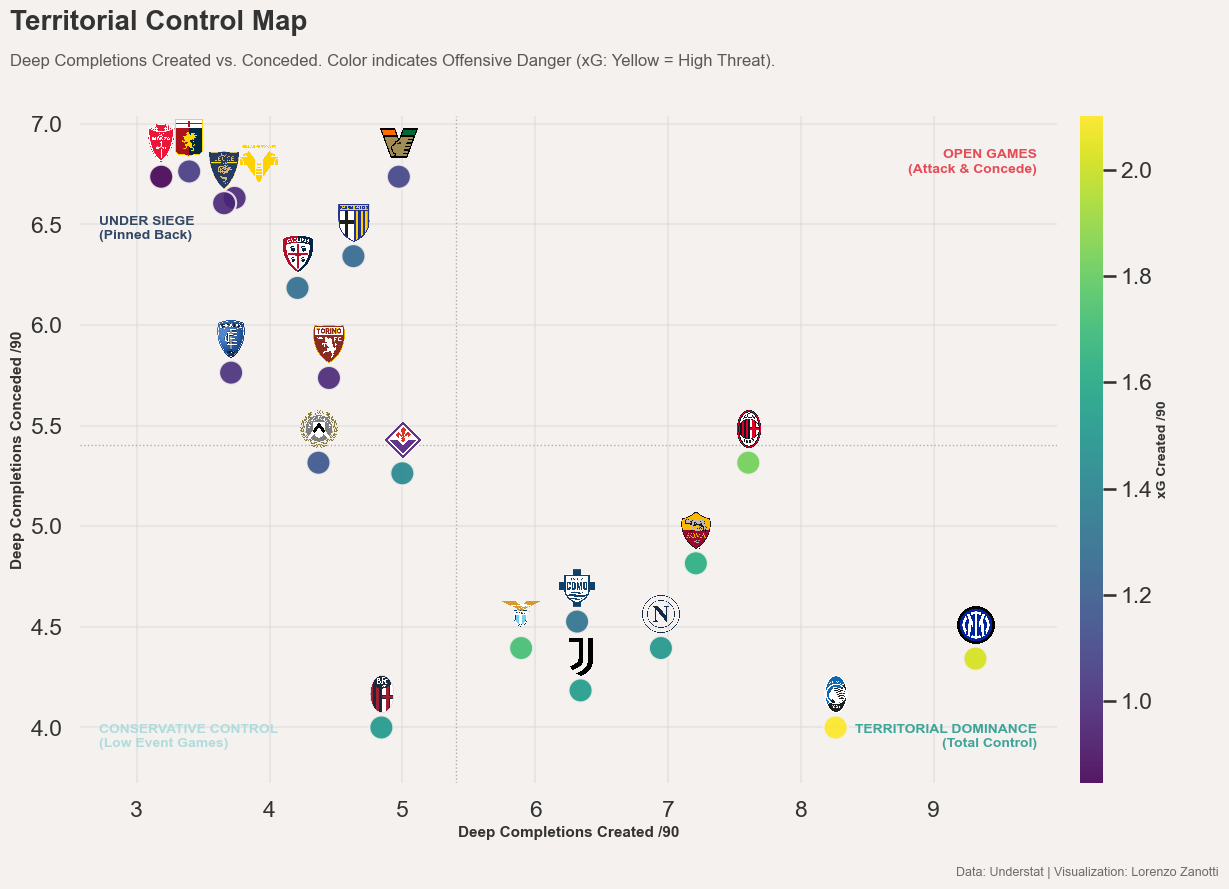

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# --- 1. SETUP STILE GIORNALISTICO (Identico agli altri) ---
BG_COLOR = '#F4F1EE'
TEXT_COLOR = '#333333'
GRID_COLOR = '#DCDCDC'

plt.rcParams.update({
    'figure.facecolor': BG_COLOR, 'axes.facecolor': BG_COLOR, 'text.color': TEXT_COLOR,
    'axes.labelcolor': TEXT_COLOR, 'xtick.color': TEXT_COLOR, 'ytick.color': TEXT_COLOR,
    'grid.color': GRID_COLOR, 'axes.spines.top': False, 'axes.spines.right': False,
    'axes.spines.left': False, 'axes.spines.bottom': False
})

# --- 2. DATI (Normalizzazione e Preparazione) ---
if "DC_per_match" not in df.columns:
    df["DC_per_match"] = df["DC"] / df["matches"]
if "ODC_per_match" not in df.columns:
    df["ODC_per_match"] = df["ODC"] / df["matches"]
if "xG_per_match" not in df.columns: # Usiamo xG per match per il colore
    df["xG_per_match"] = df["xG"] / df["matches"]

# --- 3. PLOT COMPLETO ---
fig, ax = plt.subplots(figsize=(13, 9))

# Scatter COLORATO per xG (Intensità offensiva)
# Viridis: Viola (Pochi xG) -> Giallo (Tanti xG)
scatter = ax.scatter(
    df["DC_per_match"], 
    df["ODC_per_match"], 
    c=df["xG_per_match"], 
    s=300, 
    cmap="viridis", 
    alpha=0.9,
    edgecolor=BG_COLOR,
    linewidth=1.5,
    zorder=2
)

# --- 4. LOGHI CON CORREZIONI MANUALI ---
x_min, x_max = df["DC_per_match"].min(), df["DC_per_match"].max()
y_min, y_max = df["ODC_per_match"].min(), df["ODC_per_match"].max()
margin_x = (x_max - x_min) * 0.1
margin_y = (y_max - y_min) * 0.1

ax.set_xlim(x_min - margin_x, x_max + margin_x)
ax.set_ylim(y_min - margin_y, y_max + margin_y)

for _, row in df.iterrows():
    # 1. PRIMA definisci le posizioni standard per TUTTI
    x_pos = row["DC_per_match"]
    y_pos = row["ODC_per_match"] + (margin_y * 0.6) # Alza i loghi (0.6 o 0.8 a piacere)

    # 2. POI applichi la correzione SOLO per il Verona
    if row["team"] == "Verona":
        x_pos += (margin_x * 0.3) # Sposta a destra
    
    # 3. INFINE disegni il logo usando le variabili x_pos e y_pos (NON row[...])
    add_logo(ax, x_pos, y_pos, row["team"], zoom=0.018)
# --- 5. QUADRANTI E TESTI (FIX SOVRAPPOSIZIONI) ---
x_mean = df["DC_per_match"].mean()
y_mean = df["ODC_per_match"].mean()

# Linee medie (più sottili e grigie per non disturbare)
ax.axhline(y_mean, color='#B0B0B0', linestyle=':', linewidth=1, zorder=1)
ax.axvline(x_mean, color='#B0B0B0', linestyle=':', linewidth=1, zorder=1)

# --- ETICHETTE QUADRANTI ANCORATE AGLI ANGOLI ---
# Usiamo le coordinate relative agli assi (0=inizio, 1=fine) per essere sicuri che stiano agli angoli
# In alto a DESTRA (Open Games)
ax.text(0.98, 0.95, "OPEN GAMES\n(Attack & Concede)", transform=ax.transAxes,
        ha='right', va='top', color='#E63946', fontsize=10, fontweight='bold', alpha=0.9)

# In basso a DESTRA (Territorial Dominance) - Spostato più in basso per non coprire Atalanta
ax.text(0.98, 0.05, "TERRITORIAL DOMINANCE\n(Total Control)", transform=ax.transAxes,
        ha='right', va='bottom', color='#2A9D8F', fontsize=10, fontweight='bold', alpha=0.9)

# In basso a SINISTRA (Low Block)
ax.text(0.02, 0.05, "CONSERVATIVE CONTROL\n(Low Event Games)", transform=ax.transAxes,
        ha='left', va='bottom', color='#A8DADC', fontsize=10, fontweight='bold', alpha=0.9)

# In alto a SINISTRA (Under Siege) - IL PUNTO CRITICO
# Lo mettiamo molto in alto e a sinistra, quasi "fuori" dal cluster di punti
ax.text(0.02, 0.85, "UNDER SIEGE\n(Pinned Back)", transform=ax.transAxes,
        ha='left', va='top', color='#1D3557', fontsize=10, fontweight='bold', alpha=0.9)

# --- 6. COLORBAR E TITOLI ---
cbar = plt.colorbar(scatter, ax=ax, pad=0.02, aspect=30)
cbar.set_label("xG Created /90", fontsize=10, fontweight='bold')
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_tick_params(color=TEXT_COLOR)

ax.set_xlabel("Deep Completions Created /90", fontsize=11, fontweight='bold')
ax.set_ylabel("Deep Completions Conceded /90", fontsize=11, fontweight='bold')
ax.grid(alpha=0.5)

# Header Stile "The Economist"
fig.text(0.02, 0.96, "Territorial Control Map", fontsize=20, fontweight='bold', color=TEXT_COLOR)
fig.text(0.02, 0.92, "Deep Completions Created vs. Conceded. Color indicates Offensive Danger (xG: Yellow = High Threat).", fontsize=12, color=TEXT_COLOR, alpha=0.8)
fig.text(0.95, 0.02, "Data: Understat | Visualization: Lorenzo Zanotti", ha='right', fontsize=9, color=TEXT_COLOR, alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()

### The Four Tactical Archtypes (Grafico 3)

C:\Users\loren\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


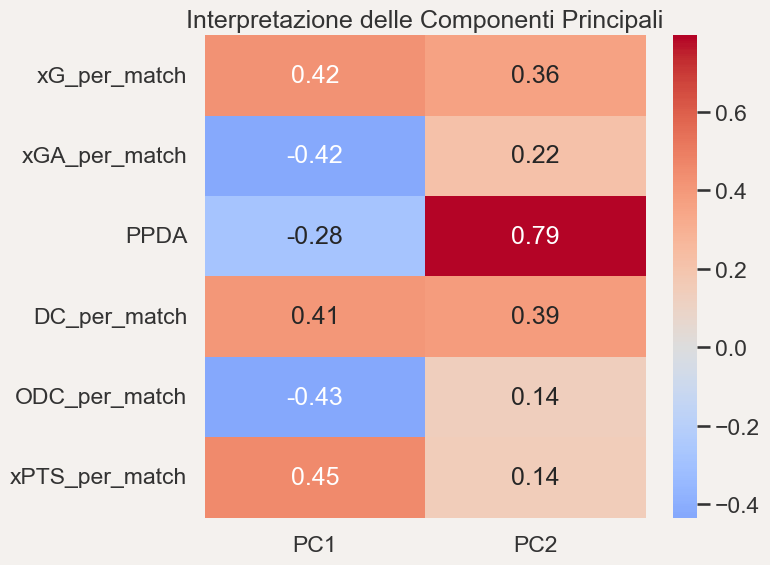

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.patheffects as path_effects

# --- 1. SETUP STILE "GIORNALISTICO CHIARO" ---
BG_COLOR = '#F4F1EE'
TEXT_COLOR = '#333333'
GRID_COLOR = '#DCDCDC'

plt.rcParams.update({
    'figure.facecolor': BG_COLOR, 'axes.facecolor': BG_COLOR, 'text.color': TEXT_COLOR,
    'axes.labelcolor': TEXT_COLOR, 'xtick.color': TEXT_COLOR, 'ytick.color': TEXT_COLOR,
    'grid.color': GRID_COLOR, 'axes.spines.top': False, 'axes.spines.right': False,
    'axes.spines.left': False, 'axes.spines.bottom': False
})

# --- 2. PREPARAZIONE DATI (UNDERSTAT) ---
# Selezioniamo le variabili chiave per definire lo stile
style_vars = [
    "xG", "xGA", "PPDA", "DC", "ODC", "xPTS", 
    "goals_for", "goals_against" # Opzionali, ma aiutano a definire l'efficacia
]

# Normalizziamo per partita se non lo sono già
for col in style_vars:
    if f"{col}_per_match" not in df.columns and col in df.columns:
         df[f"{col}_per_match"] = df[col] / df["matches"]

# Usiamo le versioni "per match" o quelle che hanno senso (PPDA è già una media)
cluster_features = [
    "xG_per_match", "xGA_per_match", "PPDA", 
    "DC_per_match", "ODC_per_match", "xPTS_per_match"
]

X = df[cluster_features].copy()
X_std = StandardScaler().fit_transform(X)

# --- 3. CLUSTERING (K=4) ---
kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
df["StyleCluster"] = kmeans.fit_predict(X_std)

# --- 4. PCA ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)
df["PC1"] = X_pca[:, 0]
df["PC2"] = X_pca[:, 1]

# Heatmap per interpretare i cluster (fondamentale per il commento!)
loadings = pd.DataFrame(
    pca.components_.T,
    index=cluster_features,
    columns=["PC1", "PC2"]
)
plt.figure(figsize=(8, 6))
sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0)
plt.title("Interpretazione delle Componenti Principali")
plt.tight_layout()
plt.show()

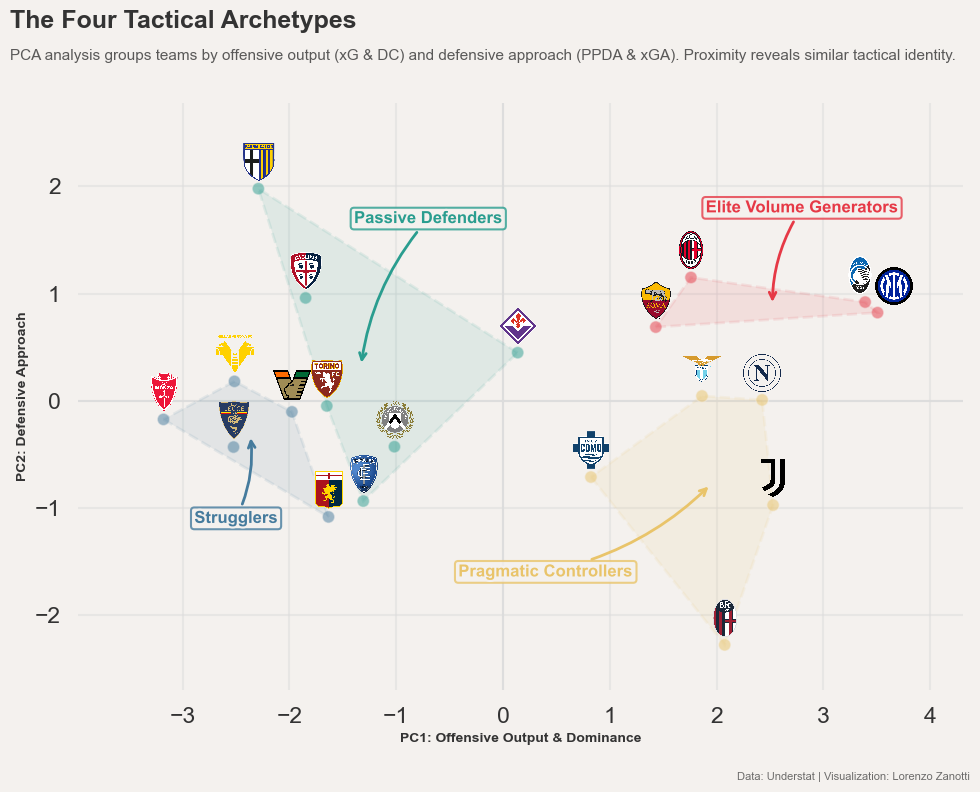

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.patheffects as path_effects

# --- 1. CONFIGURAZIONE NOMI E POSIZIONI ---
cluster_mapping = {
    0: "Elite Volume Generators",   
    1: "Strugglers",                
    2: "Pragmatic Controllers",     
    3: "Passive Defenders"          
}

# --- CONTROLLO MANUALE: DOVE METTERE LE SCRITTE ---
label_positions = {
    0: (2.8, 1.8),    # Cluster 0 (Elite - Rosso)
    1: (-2.5, -1.1),  # Cluster 1 (Strugglers - Blu)
    2: (0.4, -1.6),   # Cluster 2 (Pragmatic - Oro)
    3: (-0.7, 1.7)    # Cluster 3 (Passive - Teal)
}

# --- 2. SETUP GRAFICO ---
fig, ax = plt.subplots(figsize=(10, 8)) 

# Palette distintiva (4 colori netti)
cluster_colors = ['#E63946', '#457B9D', '#E9C46A', '#2A9D8F'] 

# Scatter base (Punti piccoli e semitrasparenti)
sns.scatterplot(
    data=df, x="PC1", y="PC2", hue="StyleCluster",
    palette=cluster_colors, s=80, alpha=0.5, 
    edgecolor=BG_COLOR, linewidth=1, ax=ax, legend=False
)

# --- 3. CONVEX HULLS + ETICHETTE CON FRECCE ---
for i, color in enumerate(cluster_colors):
    points = df[df["StyleCluster"] == i][["PC1", "PC2"]].values
    
    if len(points) > 2:
        # Disegna Area
        hull = ConvexHull(points)
        polygon = plt.Polygon(
            points[hull.vertices], closed=True, facecolor=color, alpha=0.1,
            edgecolor=color, linewidth=2, linestyle='--'
        )
        ax.add_patch(polygon)
        
        # Calcola Centro e Parametri
        center = np.mean(points, axis=0)
        label = cluster_mapping.get(i, f"Group {i+1}")
        pos_x, pos_y = label_positions.get(i, (center[0], center[1]))
        
        # DISEGNA FRECCIA E TESTO
        ax.annotate(
            label, 
            xy=(center[0], center[1]),      # Punta della freccia (Centro Cluster)
            xytext=(pos_x, pos_y),          # Posizione del testo
            textcoords='data',
            arrowprops=dict(
                arrowstyle="->",            # <--- RIPRISTINATA LA FRECCIA
                color=color,                
                lw=2, 
                connectionstyle="arc3,rad=0.15" # Curvatura elegante
            ),
            fontsize=12, fontweight='bold', color=color, ha='center', va='center',
            path_effects=[path_effects.withStroke(linewidth=3, foreground=BG_COLOR)],
            bbox=dict(boxstyle="round,pad=0.2", fc=BG_COLOR, ec=color, alpha=0.8)
        )

# --- 4. LOGHI (CON SPOSTAMENTO INTER/ATALANTA) ---
x_vals = df["PC1"]
y_vals = df["PC2"]

# Limiti assi manuali
margin_x = 0.8
ax.set_xlim(x_vals.min() - margin_x, x_vals.max() + margin_x)
ax.set_ylim(-2.7, y_vals.max() + 0.8) # Limite inferiore fisso a -2.7

for _, row in df.iterrows():
    x, y, team = row["PC1"], row["PC2"], row["team"]
    
    # --- LOGICA SPOSTAMENTO MANUALE ---
    x_pos = x
    if "Inter" in team: 
        x_pos = x + 0.15 # Inter a destra
    if "Atalanta" in team: 
        x_pos = x - 0.05 # Atalanta leggermente a sinistra
    
    # Aggiungi logo
    add_logo(ax, x_pos, y + 0.25, team, zoom=0.018) 

# --- 5. FORMATTAZIONE FINALE ---
ax.axhline(0, color=GRID_COLOR, linestyle='-', linewidth=1.5, alpha=0.8, zorder=0)
ax.axvline(0, color=GRID_COLOR, linestyle='-', linewidth=1.5, alpha=0.8, zorder=0)
ax.grid(alpha=0.5)

ax.set_xlabel("PC1: Offensive Output & Dominance", fontsize=10, fontweight='bold')
ax.set_ylabel("PC2: Defensive Approach", fontsize=10, fontweight='bold')

# Titoli
fig.text(0.02, 0.96, "The Four Tactical Archetypes", fontsize=18, fontweight='bold', color=TEXT_COLOR)
fig.text(0.02, 0.92, "PCA analysis groups teams by offensive output (xG & DC) and defensive approach (PPDA & xGA). Proximity reveals similar tactical identity.", fontsize=11, color=TEXT_COLOR, alpha=0.8)
fig.text(0.98, 0.02, "Data: Understat | Visualization: Lorenzo Zanotti", ha='right', fontsize=8, color=TEXT_COLOR, alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()

### Clinicians vs Wasteful (Grafico 4)

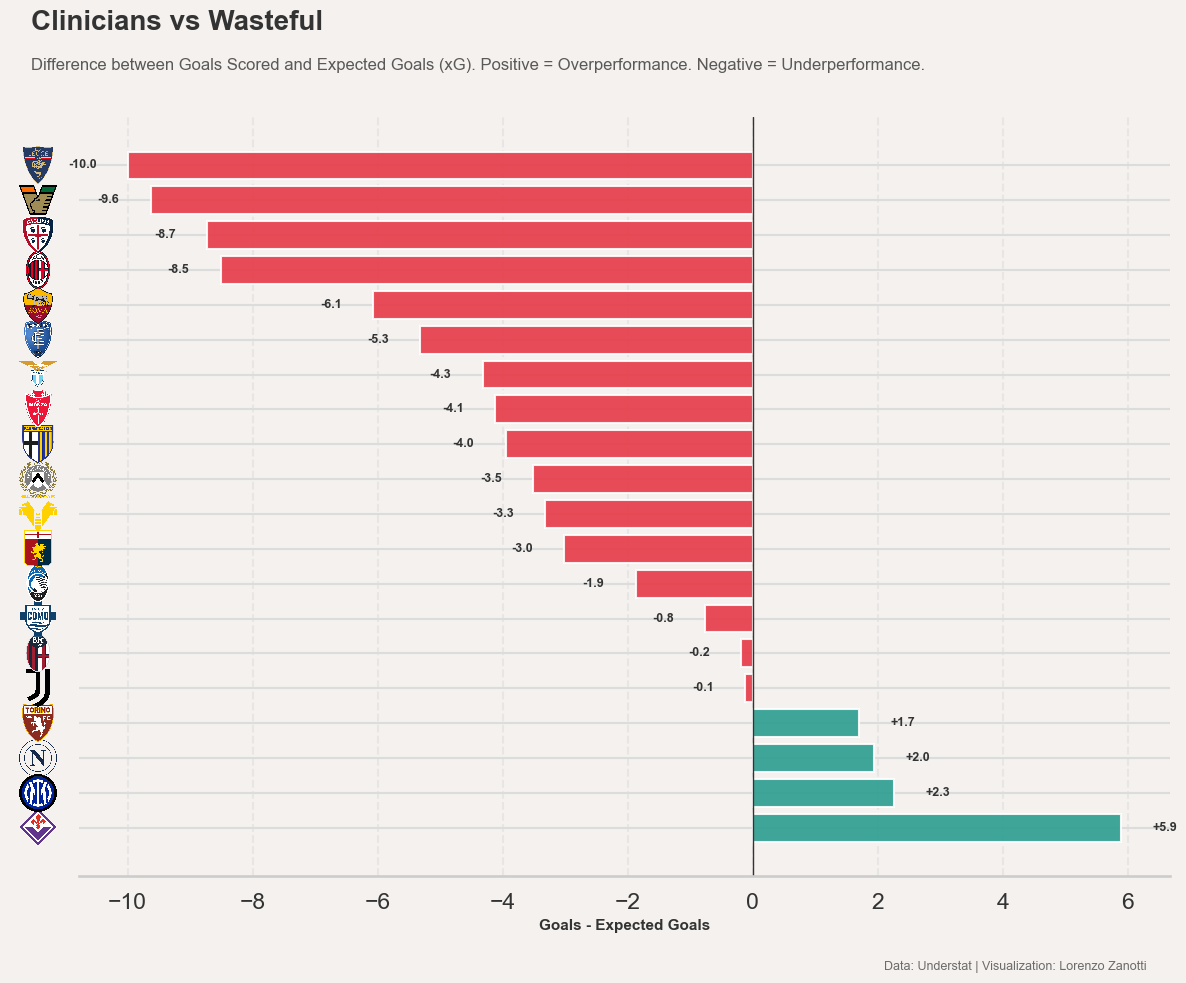

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.image import imread

# --- 1. SETUP STILE ---
BG_COLOR = '#F4F1EE'
TEXT_COLOR = '#333333'
GRID_COLOR = '#DCDCDC'
plt.rcParams.update({
    'figure.facecolor': BG_COLOR, 
    'axes.facecolor': BG_COLOR, 
    'text.color': TEXT_COLOR, 
    'axes.labelcolor': TEXT_COLOR, 
    'xtick.color': TEXT_COLOR, 
    'ytick.color': TEXT_COLOR, 
    'grid.color': GRID_COLOR, 
    'axes.spines.top': False, 
    'axes.spines.right': False, 
    'axes.spines.left': False, 
    'axes.spines.bottom': True
})

# --- LOGHI DELLE SQUADRE ---
logo_dir = r"C:\Users\loren\OneDrive\Desktop\Data Science\Data Visualization\Loghi Serie A"
team_logo_map = {
    "Napoli": os.path.join(logo_dir, "Napoli.png"),
    "Inter": os.path.join(logo_dir, "Inter.png"),
    "Atalanta": os.path.join(logo_dir, "Atalanta.png"),
    "Juventus": os.path.join(logo_dir, "Juventus.png"),
    "Roma": os.path.join(logo_dir, "Roma.png"),
    "Fiorentina": os.path.join(logo_dir, "Fiorentina.png"),
    "Lazio": os.path.join(logo_dir, "Lazio.png"),
    "Milan": os.path.join(logo_dir, "Milan.png"),
    "Bologna": os.path.join(logo_dir, "Bologna.png"),
    "Como": os.path.join(logo_dir, "Como.png"),
    "Torino": os.path.join(logo_dir, "Torino.png"),
    "Udinese": os.path.join(logo_dir, "Udinese.png"),
    "Genoa": os.path.join(logo_dir, "Genoa.png"),
    "Verona": os.path.join(logo_dir, "Verona.png"),
    "Parma": os.path.join(logo_dir, "Parma.png"),
    "Cagliari": os.path.join(logo_dir, "Cagliari.png"),
    "Lecce": os.path.join(logo_dir, "Lecce.png"),
    "Empoli": os.path.join(logo_dir, "Empoli.png"),
    "Venezia": os.path.join(logo_dir, "Venezia.png"),
    "Monza": os.path.join(logo_dir, "Monza.png"),
}

# --- 2. DATI ---
# Calcoliamo la differenza G - xG
df["G_minus_xG"] = df["goals_for"] - df["xG"]
# Ordiniamo dal più cinico al più sprecone
df_eff = df.sort_values("G_minus_xG", ascending=False)

# --- 3. PLOT ---
fig, ax = plt.subplots(figsize=(12, 10))

# Colori divergenti: Verde (Positivo) -> Rosso (Negativo)
colors = ['#2A9D8F' if x >= 0 else '#E63946' for x in df_eff["G_minus_xG"]]

# Barre più sottili per creare spazio verticale
bars = ax.barh(df_eff["team"], df_eff["G_minus_xG"], color=colors, alpha=0.9)

# --- 4. RIFINITURE ---
ax.axvline(0, color=TEXT_COLOR, linewidth=1)
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Etichette sui valori
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.5 if width > 0 else width - 0.5
    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{width:+.1f}', 
            va='center', ha='left' if width > 0 else 'right', 
            fontsize=9, fontweight='bold', color=TEXT_COLOR)

# --- 5. SOSTITUIAMO I NOMI CON I LOGHI ---
# Nascondiamo le etichette di testo originali
ax.set_yticklabels([])

# Aggiungiamo i loghi al posto dei nomi
for idx, (i, row) in enumerate(df_eff.iterrows()):
    team = row["team"]
    path = team_logo_map.get(team)
    
    if path and os.path.exists(path):
        try:
            # Leggiamo l'immagine
            img = imread(path)
            
            # Creiamo l'OffsetImage con zoom ridotto per eleganza
            imagebox = OffsetImage(img, zoom=0.018)
            
            # Posizioniamo il logo vicino all'asse y
            ab = AnnotationBbox(imagebox, (-0.02, idx), 
                              xycoords=('axes fraction', 'data'),
                              box_alignment=(1, 0.5),
                              frameon=False)
            ax.add_artist(ab)
        except Exception as e:
            print(f"Errore caricamento logo {team}: {e}")
    else:
        print(f"Logo non trovato per {team}")

# Titoli
ax.set_xlabel("Goals - Expected Goals", fontsize=11, fontweight='bold')
ax.set_ylabel("")
fig.text(0.02, 0.96, "Clinicians vs Wasteful", 
         fontsize=20, fontweight='bold', color=TEXT_COLOR)
fig.text(0.02, 0.92, "Difference between Goals Scored and Expected Goals (xG). Positive = Overperformance. Negative = Underperformance.", 
         fontsize=12, color=TEXT_COLOR, alpha=0.8)
fig.text(0.95, 0.02, "Data: Understat | Visualization: Lorenzo Zanotti", 
         ha='right', fontsize=9, color=TEXT_COLOR, alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.subplots_adjust(left=0.06)
plt.show()

### Reality vs Expectation (Grafico 5)

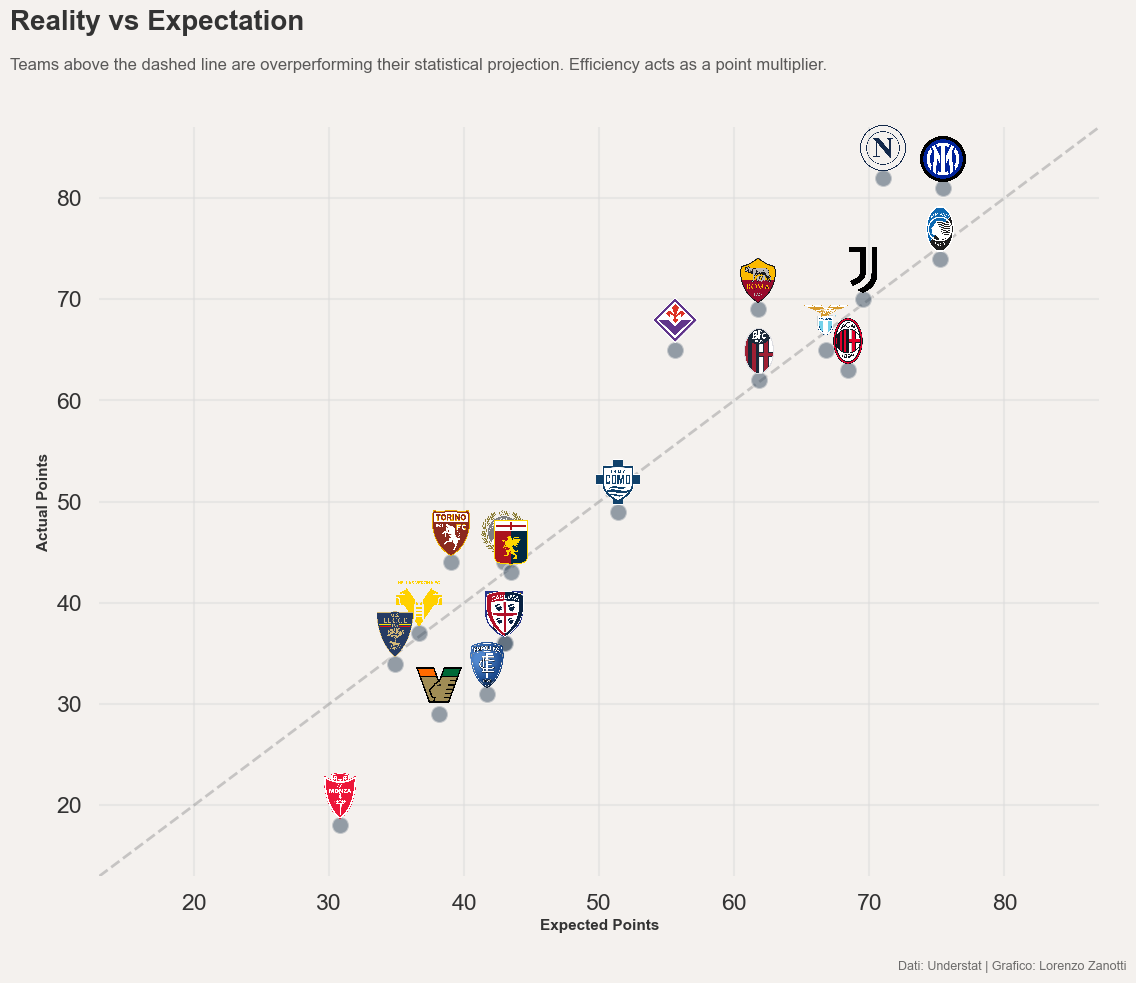

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import os

# --- 1. SETUP STILE ---
BG_COLOR = '#F4F1EE'
TEXT_COLOR = '#333333'
GRID_COLOR = '#DCDCDC'

plt.rcParams.update({
    'figure.facecolor': BG_COLOR, 'axes.facecolor': BG_COLOR, 'text.color': TEXT_COLOR,
    'axes.labelcolor': TEXT_COLOR, 'xtick.color': TEXT_COLOR, 'ytick.color': TEXT_COLOR,
    'grid.color': GRID_COLOR, 'axes.spines.top': False, 'axes.spines.right': False,
    'axes.spines.left': False, 'axes.spines.bottom': False
})

# --- 2. DATI ---
excel_path = r"C:\Users\loren\Downloads\UnderStat24-25.xlsx"
df = pd.read_excel(excel_path)

# Pulizia
def clean_metric(val):
    if isinstance(val, str):
        import re
        match = re.match(r"^-?\d+(\.\d+)?", val)
        if match: return float(match.group(0))
    return val

for col in ['xPTS', 'PTS']:
    if col in df.columns:
        df[col] = df[col].apply(clean_metric).astype(float)

# --- 3. MAPPING LOGHI ---
logo_dir = r"C:\Users\loren\OneDrive\Desktop\Data Science\Data Visualization\Loghi Serie A"
team_logo_map = {
    "Napoli": "Napoli.png", "Inter": "Inter.png", "Atalanta": "Atalanta.png",
    "Juventus": "Juventus.png", "Roma": "Roma.png", "Fiorentina": "Fiorentina.png",
    "Lazio": "Lazio.png", "Milan": "Milan.png", "Bologna": "Bologna.png",
    "Como": "Como.png", "Torino": "Torino.png", "Udinese": "Udinese.png",
    "Genoa": "Genoa.png", "Verona": "Verona.png", "Parma": "Parma.png",
    "Cagliari": "Cagliari.png", "Lecce": "Lecce.png", "Empoli": "Empoli.png",
    "Venezia": "Venezia.png", "Monza": "Monza.png",
}

def add_logo(ax, x, y, team, zoom=0.06):
    filename = team_logo_map.get(team)
    if filename:
        path = os.path.join(logo_dir, filename)
        if os.path.exists(path):
            img = mpimg.imread(path)
            im = OffsetImage(img, zoom=zoom)
            ab = AnnotationBbox(im, (x, y), frameon=False)
            ax.add_artist(ab)

# --- 4. PLOT ---
fig, ax = plt.subplots(figsize=(12, 10)) # Dimensioni generose come il Cluster

# Limiti dinamici (Zoomati)
all_pts = pd.concat([df['xPTS'], df['PTS']])
margin = 5
g_min, g_max = all_pts.min() - margin, all_pts.max() + margin

# Diagonale
ax.plot([g_min, g_max], [g_min, g_max], ls='--', color='#999999', alpha=0.5, lw=2, zorder=1)

# SCATTER: PARAMETRI "CLUSTER STYLE"
sns.scatterplot(
    data=df, x='xPTS', y='PTS',
    s=150,             # <--- GRANDEZZA MASSICCIA (Bolle)
    color='#34495E',   # Grigio neutro elegante
    alpha=0.5,         # Trasparenza per vedere la griglia sotto
    edgecolor=BG_COLOR,
    linewidth=1.5,
    ax=ax,
    zorder=2
)

# LOGHI: Posizionamento "tight"
for _, row in df.iterrows():
    # Offset ridotto: +1.8 (invece di 2.5). 
    # Con s=300, questo mette il logo appena sopra il centro della bolla.
    y_logo = row['PTS'] + 2.9
    
    # Zoom: 0.020 (Bilanciato con la bolla da 300)
    add_logo(ax, row['xPTS'], y_logo, row['Team'], zoom=0.022)

# --- 5. FINITURE ---
ax.set_xlabel("Expected Points", fontsize=11, fontweight='bold')
ax.set_ylabel("Actual Points", fontsize=11, fontweight='bold')
ax.set_xlim(g_min, g_max)
ax.set_ylim(g_min, g_max)
ax.grid(alpha=0.5)

# Titoli
fig.text(0.02, 0.96, "Reality vs Expectation",
         fontsize=20, fontweight='bold', ha='left', color=TEXT_COLOR)
fig.text(0.02, 0.92, "Teams above the dashed line are overperforming their statistical projection. Efficiency acts as a point multiplier.",
         fontsize=12, ha='left', color=TEXT_COLOR, alpha=0.8)

# Footer
fig.text(0.95, 0.02, "Dati: Understat | Grafico: Lorenzo Zanotti", ha='right', fontsize=9, color=TEXT_COLOR, alpha=0.7)

plt.tight_layout(rect=[0.02, 0.03, 0.95, 0.90])
plt.show()

### Milan's Trade-Off (Grafico 6)

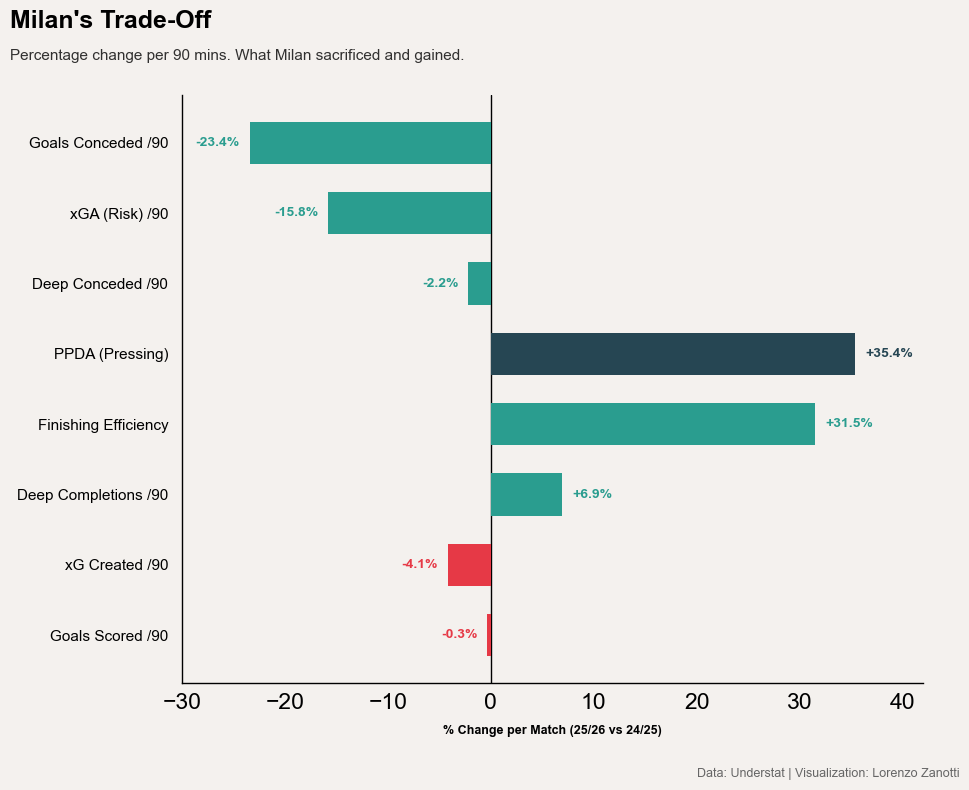

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# --- 1. SETUP STILE ---
BG_COLOR = '#F4F1EE'
TEXT_COLOR = '#333333' # Nero puro

# I TUOI COLORI
POS_COLOR = '#2A9D8F' 
NEG_COLOR = '#E63946' 
NEUT_COLOR = '#264653' 

plt.rcParams.update({
    'figure.facecolor': BG_COLOR, 
    'axes.facecolor': BG_COLOR, 
    'text.color': TEXT_COLOR,
    'axes.labelcolor': TEXT_COLOR, 
    'xtick.color': TEXT_COLOR, 
    'ytick.color': TEXT_COLOR,
    'axes.spines.top': False, 
    'axes.spines.right': False, 
    'axes.spines.left': True,   
    'axes.spines.bottom': True, 
    'font.family': 'sans-serif'
})

# --- 2. DATI ---
file_path = 'Confronto MILAN.xlsx'
df = pd.read_excel(file_path)
df['Season'] = df['Season'].astype(str).str.strip()

def clean_metric(val):
    if isinstance(val, str):
        match = re.search(r"[-+]?\d*\.\d+|\d+", val)
        if match: return float(match.group())
    return float(val)

for col in ['xG', 'xGA', 'xPTS', 'DC', 'ODC', 'G', 'GA', 'PPDA']:
    if col in df.columns:
        df[col] = df[col].apply(clean_metric)

# Calcoli P90
df['xG_pm'] = df['xG'] / df['M']
df['G_pm'] = df['G'] / df['M']
df['xGA_pm'] = df['xGA'] / df['M']
df['GA_pm'] = df['GA'] / df['M']
df['DC_pm'] = df['DC'] / df['M']
df['ODC_pm'] = df['ODC'] / df['M']
df['PPDA_val'] = df['PPDA']
df['Efficiency_pm'] = df['G_pm'] - df['xG_pm']

s24 = df[df['Season']=='24/25'].iloc[0]
s25 = df[df['Season']=='25/26'].iloc[0]

# --- 3. CONFIGURAZIONE PLOT ---
metrics_ordered = [
    ('GA_pm', 'Goals Conceded /90'), 
    ('xGA_pm', 'xGA (Risk) /90'),
    ('ODC_pm', 'Deep Conceded /90'), 
    ('PPDA_val', 'PPDA (Pressing)'),
    ('Efficiency_pm', 'Finishing Efficiency'), 
    ('DC_pm', 'Deep Completions /90'), 
    ('xG_pm', 'xG Created /90'),
    ('G_pm', 'Goals Scored /90')
]

diffs = []
colors = []
labels = []
text_labels = []

for col, label in metrics_ordered:
    val24 = s24[col]
    val25 = s25[col]
    
    if col == 'Efficiency_pm':
        pct = ((val25 - val24) / abs(val24)) * 100
    else:
        pct = ((val25 - val24) / val24) * 100
    
    diffs.append(pct)
    labels.append(label)
    text_labels.append(f"{pct:+.1f}%")

    if col in ['GA_pm', 'xGA_pm', 'ODC_pm']:
        colors.append(POS_COLOR if pct < 0 else NEG_COLOR)
    elif col == 'PPDA_val':
        colors.append(NEUT_COLOR)
    else:
        colors.append(POS_COLOR if pct > 0 else NEG_COLOR)

# --- 4. CREAZIONE GRAFICO ---
fig, ax = plt.subplots(figsize=(10, 8))
y_pos = np.arange(len(metrics_ordered))

# >>> NESSUNA GRIGLIA (Come prima) <<<
ax.grid(False)

# Linea Zero Nera
ax.axvline(0, color='black', linewidth=1.0, alpha=1.0, zorder=2)

# Barre
ax.barh(y_pos, diffs, color=colors, height=0.6, zorder=3, edgecolor='none')

# Etichette valori
for i, v in enumerate(diffs):
    offset = 1 if v >= 0 else -1
    ha = 'left' if v >= 0 else 'right'
    ax.text(v + offset, i, text_labels[i], va='center', ha=ha, 
            fontweight='bold', fontsize=10, color=colors[i], zorder=5)

# --- SETUP ASSI ---
ax.invert_yaxis()
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=11, fontweight='normal', color='black')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(1.0)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(1.0)

ax.tick_params(axis='y', colors='black', length=0, pad=10) 
ax.tick_params(axis='x', colors='black', length=4, width=1) 

ax.set_xlim(-30, 42)
ax.set_xlabel('% Change per Match (25/26 vs 24/25)', fontweight='bold', fontsize=9, labelpad=8, color='black')

# Titoli
fig.text(0.04, 0.95, "Milan's Trade-Off", fontsize=18, fontweight='bold', color='black')
fig.text(0.04, 0.91, "Percentage change per 90 mins. What Milan sacrificed and gained.", fontsize=11, alpha=0.8, color='black')

# >>> FOOTER AGGIUNTO <<<
fig.text(0.99, 0.01, "Data: Understat | Visualization: Lorenzo Zanotti", 
         ha='right', va='bottom', fontsize=9, color='#666666')

plt.tight_layout(rect=[0.02, 0.03, 0.98, 0.90])
plt.show()

### The Structural Transformation (Grafico 7)

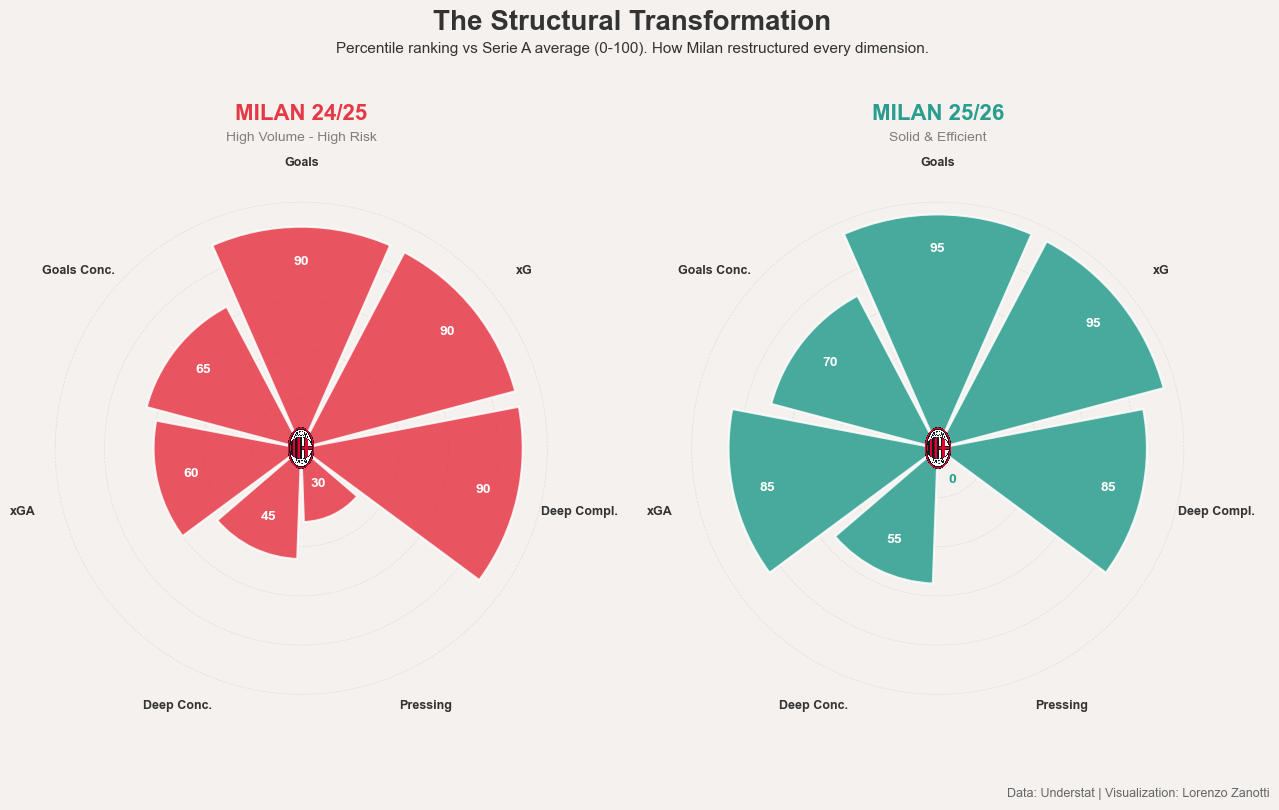

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from scipy.stats import percentileofscore
import re
import os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.image import imread

# ---------------------------------------------------------
# SETUP STILE
# ---------------------------------------------------------
BG_COLOR = '#F4F1EE'
TEXT_COLOR = '#333333'
COLOR_24 = '#E63946' 
COLOR_25 = '#2A9D8F' 

plt.rcParams.update({
    'figure.facecolor': BG_COLOR, 
    'axes.facecolor': BG_COLOR, 
    'text.color': TEXT_COLOR
})

# ---------------------------------------------------------
# LOGHI
# ---------------------------------------------------------
logo_dir = r"C:\Users\loren\OneDrive\Desktop\Data Science\Data Visualization\Loghi Serie A"
team_logo_map = {
    "Milan": os.path.join(logo_dir, "Milan.png")
}

def add_logo_polar(ax, team, zoom=0.15):
    """Aggiunge logo al centro di un grafico polare"""
    path = team_logo_map.get(team)
    if path is None or not os.path.exists(path):
        return
    img = imread(path)
    im = OffsetImage(img, zoom=zoom)
    ab = AnnotationBbox(im, (0, 0), frameon=False, box_alignment=(0.5, 0.5))
    ax.add_artist(ab)

# ---------------------------------------------------------
# FUNZIONI DI CARICAMENTO DATI
# ---------------------------------------------------------
def smart_clean(val):
    if pd.isna(val): 
        return 0.0
    if isinstance(val, (int, float)): 
        return float(val)
    val_str = str(val).strip()
    if '-' in val_str and not val_str.startswith('-'): 
        val_str = val_str.split('-')[0]
    elif '+' in val_str: 
        val_str = val_str.split('+')[0]
    match = re.search(r"[-+]?\d*\.\d+|[-+]?\d+", val_str)
    return float(match.group()) if match else 0.0

def load_and_prep(path):
    df = pd.read_excel(path)
    metrics_raw = ['xG', 'G', 'xGA', 'GA', 'DC', 'ODC', 'PPDA']
    
    # Rinomina se necessario
    rename_map = {'Deep': 'DC', 'Deep_Allowed': 'ODC'}
    df.rename(columns=rename_map, inplace=True)

    for col in metrics_raw:
        if col in df.columns:
            df[col] = df[col].apply(smart_clean)
            if col != 'PPDA':
                df[f'{col}_p90'] = df[col] / df['M']
            else:
                df[f'{col}_val'] = df[col]
    return df

# Caricamento dati
df24 = load_and_prep(r"C:\Users\loren\Downloads\UnderStat24-25.xlsx")
df25 = load_and_prep(r"C:\Users\loren\Downloads\UnderStat25-26.xlsx")

# ---------------------------------------------------------
# CONFIGURAZIONE METRICHE
# ---------------------------------------------------------
metrics_cfg = [
    {'col': 'G_p90', 'label': 'Goals', 'invert': False},
    {'col': 'xG_p90', 'label': 'xG', 'invert': False},
    {'col': 'DC_p90', 'label': 'Deep Compl.', 'invert': False},
    {'col': 'PPDA_val', 'label': 'Pressing', 'invert': True}, 
    {'col': 'ODC_p90', 'label': 'Deep Conc.', 'invert': True}, 
    {'col': 'xGA_p90', 'label': 'xGA', 'invert': True},      
    {'col': 'GA_p90', 'label': 'Goals Conc.', 'invert': True} 
]

# ---------------------------------------------------------
# CALCOLO PERCENTILI
# ---------------------------------------------------------
def get_team_percentiles(df, team_name='Milan'):
    team_row = df[df['Team'].astype(str).str.contains(team_name, case=False, na=False)]
    if team_row.empty: 
        return [0]*len(metrics_cfg), [0]*len(metrics_cfg)
    
    team_stats = team_row.iloc[0]
    percentiles, raw_values = [], []
    
    for m in metrics_cfg:
        col = m['col']
        if col not in df.columns:
            percentiles.append(0)
            raw_values.append(0)
            continue
        
        val = team_stats[col]
        all_vals = df[col].dropna().values
        pct = percentileofscore(all_vals, val, kind='weak')
        if m['invert']: 
            pct = 100 - pct
        percentiles.append(pct)
        raw_values.append(val)
        
    return percentiles, raw_values

p24, v24 = get_team_percentiles(df24, 'Milan')
p25, v25 = get_team_percentiles(df25, 'Milan')

# ---------------------------------------------------------
# GENERAZIONE GRAFICO CON FOOTER
# ---------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 8.5), subplot_kw=dict(polar=True))

def create_pizza_optimized(ax, percentiles, color, title, subtitle):
    N = len(metrics_cfg)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    width = 2 * pi / N
    
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    # Background Rings
    for i in [20, 40, 60, 80, 100]:
        ax.bar(angles, [i]*N, width=width, color='white', edgecolor='#E0E0E0', 
               linewidth=0.5, alpha=0.0, zorder=0)
        ax.plot(np.linspace(0, 2*pi, 100), [i]*100, color='#CCCCCC', 
                linestyle='--', linewidth=0.5, alpha=0.5)
    
    # Barre percentili
    bars = ax.bar(angles, percentiles, width=width*0.92, color=color, 
                  alpha=0.85, edgecolor='white', linewidth=1.5, zorder=2)
    
    # Etichette Assi
    ax.set_xticks(angles)
    ax.set_xticklabels([m['label'] for m in metrics_cfg], size=9, 
                       fontweight='bold', color=TEXT_COLOR)
    
    # Valori Rank
    for angle, p in zip(angles, percentiles):
        if p > 15:
            ax.text(angle, p - 14, f"{int(p)}", ha='center', va='center', 
                   color='white', fontweight='bold', fontsize=10, zorder=3)
        else:
            ax.text(angle, p + 14, f"{int(p)}", ha='center', va='center', 
                   color=color, fontweight='bold', fontsize=10, zorder=3)
    
    ax.set_yticks([])
    ax.spines['polar'].set_visible(False)
    ax.grid(False)
    
    # Logo
    add_logo_polar(ax, 'Milan', zoom=0.020) 
    
    # Titoli
    ax.set_title(title, y=1.12, fontsize=16, fontweight='bold', color=color)
    ax.text(0, 125, subtitle, ha='center', fontsize=10, alpha=0.6, color=TEXT_COLOR)

# Creazione dei due radar
create_pizza_optimized(ax1, p24, COLOR_24, "MILAN 24/25", "High Volume - High Risk")
create_pizza_optimized(ax2, p25, COLOR_25, "MILAN 25/26", "Solid & Efficient")

# Titolo Principale
fig.suptitle("The Structural Transformation", fontsize=20, fontweight='bold', 
             color=TEXT_COLOR, y=0.94)
fig.text(0.5, 0.89, "Percentile ranking vs Serie A average (0-100). How Milan restructured every dimension.", 
         ha='center', fontsize=11)

# Footer Crediti
fig.text(0.99, 0.01, "Data: Understat | Visualization: Lorenzo Zanotti", 
         ha='right', va='bottom', fontsize=9, color='#666666')

# Layout
plt.tight_layout(rect=[0, 0.03, 1, 0.88]) 
plt.show()